# Projet numérique de science des données - ALMECIJA César et VERNET Gabrielle

## Introduction au projet

Il s'agit dans ce projet d'utiliser des données cartographiques décrivant des carrées de 30m x 30m pour construire un modèle prédictif de l'espèce d'arbre présente sur un tel carré.

Le but final est d'appliquer ce modèle pour faire des prédictions pour des données pour lesquelles vous ne disposez pas d'une étiquette.

__Consignes :__ 
* Vous devez rendre, par binôme :
    * un notebook jupyter
    * un fichier de prédictions (voir plus bas pour le format)
* __Renseignez vos noms/prénoms__ dans le titre du notebook
* Vous avez jusqu'au __1er juillet midi heure de Paris__
* Déposez vos fichiers [sur Campus](https://campus.mines-paristech.fr/course/view.php?id=404) dans la section dédiée (un seul rendu par binôme est nécessaire)


__Déroulé :__
* Les séances du lundi 14/06 (15h30-17h) et jeudi 24/06 (15h30-17h) sont dédiées au projet numérique. Faites-en bon usage.
* Certaines sections font appel à des notions qui n'auront pas encore été vues le 14/06 ; c'est indiqué le cas échéant.

## Données

### Données publiques et privées

Le dossier `data/` contient deux jeux de données :
* `data/foret_public.tsv` contient les données étiquetées, à partir desquelles construire votre modèle
* `data/foret_prive.tsv` contient les données non-étiquetées, pour lesquelles faire vos prédictions.

Chaque ligne dans les données correspond à un carré de 30 m x 30m, décrit par les variables suivantes :
* `altitude` : altitude en mètres
* `exposition` : azimut en degrés 
* `pente` : pente en degrés
* `distance_horizontale_hydro` : distance horizontale au point d'eau le plus proche (en mètres)
* `distance_verticale_hydro` : distance verticale au point d'eau le plus proche (en mètres)
* `distance_horizontale_route` : distance horizontale à la route la plus proche (en mètres)
* `ombrage_0900` : index d'ombrages à 9h du matin, au solstice, sur une échelle de 0 à 255
* `ombrage_1200` : index d'ombrages à midi, au solstice, sur une échelle de 0 à 255
* `ombrage_1500` : index d'ombrages à 15h, au solstice, sur une échelle de 0 à 255
* `distance_horizontale_depart_feu` : distance horizontale au départ de feu de forêt le plus proche (en mètres)
* `espece` : étiquette : espèce d'arbre présente (0 = pin tordu ; 1 = peuplier)|

### Chargement des données étiquetées

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd

In [3]:
df_public = pd.read_csv('data/foret_public.tsv', delimiter='\t')

In [4]:
df_public.head()

,altitude,exposition,pente,distance_horizontale_hydro,distance_verticale_hydro,distance_horizontale_route,ombrage_0900,ombrage_1200,ombrage_1500,distance_horizontale_depart_feu,espece
0,2804,139,9,268,65,3180,234,238,135,6121,0
1,2785,155,18,242,118,3090,238,238,122,6211,0
2,2579,132,6,300,-15,67,230,237,140,6031,0
3,2886,151,11,371,26,5253,234,240,136,4051,0
4,2742,134,22,150,69,3215,248,224,92,6091,0


### Extraction de la matrice de design et des étiquettes 

In [5]:
X_public = np.array(df_public.drop(columns=["espece"]))
y_public = np.array(df_public["espece"])

### Visualisation des variables

#### Question 1
Visualisez chacune des variables de `X_public` sous la forme de deux histogrammes superposés, l'un correspondant aux observations de la classe positive, l'autre correspondant aux observations de la classe négative.

__Conseils :__
* utilisez `pos_indices = np.where(y_public==1)[0]` pour déterminer les indices des lignes de `y_public` (et donc dans `X_public`) dont l'étiquette vaut 0.
* utilisez l'argument `alpha` de `plt.hist` pour rendre vos histogrammes transparents.

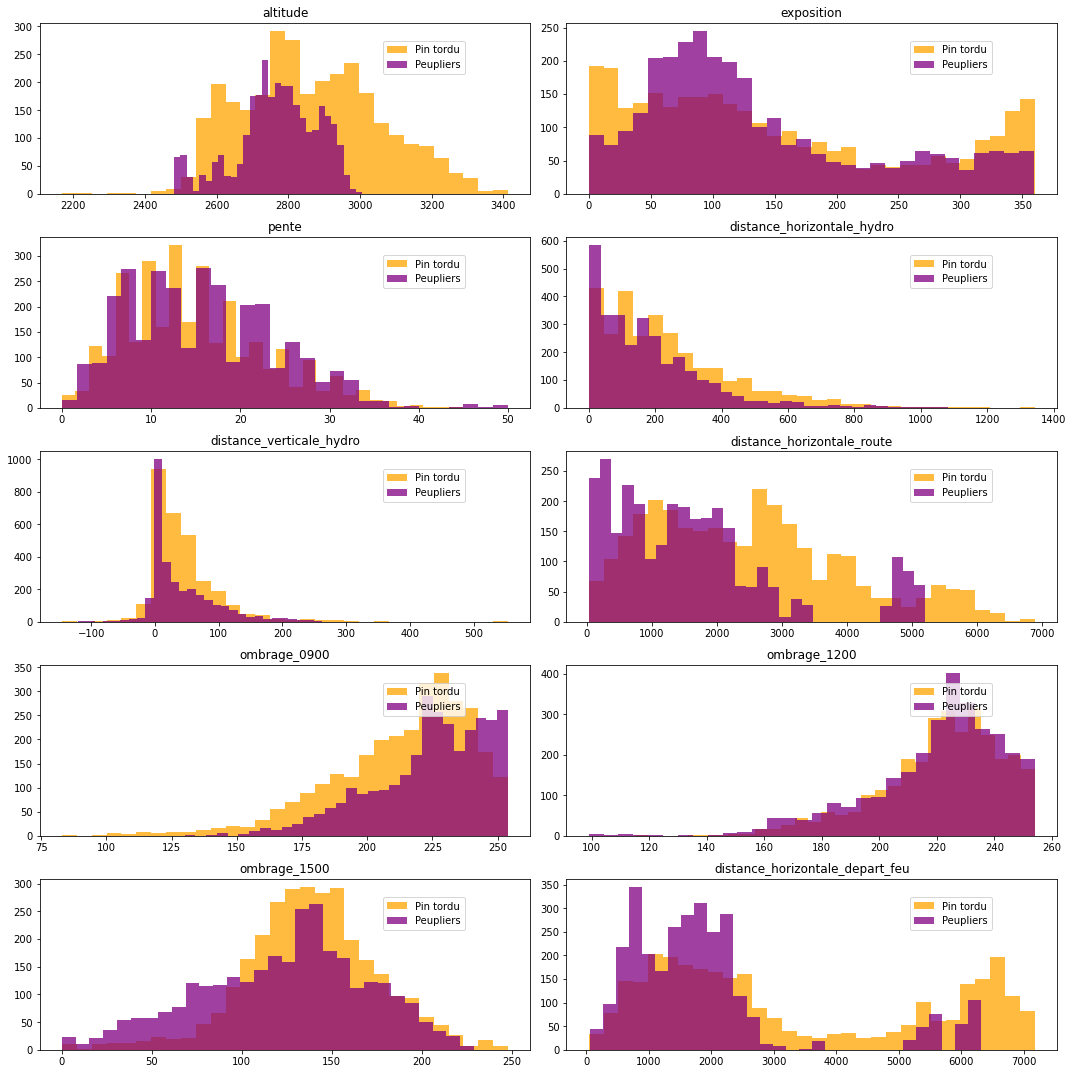

In [6]:
nb_var = X_public.shape[1]
columns_names = df_public.drop(columns=["espece"]).columns

# indices où il y a la classe positive
pos_indices_peupliers = np.where(y_public==1)[0]
# indices où il y a la classe négative
pos_indices_pins = np.where(y_public==0)[0]

fig = plt.figure(figsize=(15, 15))

for var in range(nb_var):
    ax = fig.add_subplot(5, 2, (var+1))
    h = ax.hist(X_public[pos_indices_pins, var], bins=30, edgecolor='none', color='orange', alpha=0.75, 
               label='Pin tordu')
    h = ax.hist(X_public[pos_indices_peupliers, var], bins=30, edgecolor='none', color='purple', alpha=0.75,
               label='Peupliers')
    
    ax.set_title("%s" % columns_names[var])
    
    ax.legend(loc=(0.7, 0.7))

fig.tight_layout(pad=1.0)

#### Question 2
Pensez-vous qu'il va être aisé de distinguer les deux classes ?

__Réponse__ : La majorité des variables ont une distribution similaire dans chacune des deux classes. La distinction ne sera donc pas aisée.

### Pré-traitement des variables

#### Question 3
Transformez vos variables d'une manière qui vous parait judicieuse, en vous appuyant notamment sur la PC 3. Vous pouvez essayer différents pré-traitements, mais ce n'est pas nécessaire. Justifiez vos choix. Utilisez un array numpy `X_public_preprocessed` pour enregistrer le résultat.

__Réponse__ : La distribution de la majorité des variables n'est pas normale. On va donc les transformer pour les faire ressembler à des gaussiennes. On peut utiliser l'algorithme de Box-Cox ou celui de Yeo-Johnson.

Cependant, à l'aide de la visualisation, on remarque qu'un certain nombre de valeurs sont nulles (voire négatives). Ainsi, **on utilisera l'algorithme de Yeo-Johnson**.

In [7]:
from sklearn import preprocessing

In [8]:
yeo_scaler = preprocessing.PowerTransformer(method='yeo-johnson')
yeo_scaler.fit(X_public)
X_public_preprocessed = yeo_scaler.transform(X_public)

## Premier modèle : 5-NN

### Algorithme des k plus proches voisins

Nous n'avons pas encore vu d'algorithme permettant d'entraîner un modèle de classification. Nous allons donc commencer avec un modèle simple : celui des __k plus proches voisins__ (ou __kNN__, pour _k nearest neighbors_).

Dans ce modèle, la valeur de la fonction de décision en x est la proportion d'individus d'étiquette positive parmi les k plus proches voisins de x au sein des points du jeu d'entraînement ; k est fixé.

Nous allons commencer par utiliser un algorithme des k plus proches voisins avec k fixé à k=5.

#### Question 4

Entraînez un modèle sur les données `(X_public_preprocessed, y_public)` grâce à la classe `KNeighborsClassifier` du module `neighbors` de `sklearn`, utilisez l'algorithme des 5 plus proches voisins pour entrainer un modèle sur votre jeu d'entraînement.

Documentation https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [9]:
from sklearn import neighbors

In [10]:
classifier = neighbors.KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_public_preprocessed, y_public)

KNeighborsClassifier()

### Performance

Il existe de nombreuses métriques pour évaluer les performances d'un algorithme de classification. Nous allons ici utiliser le F-score, dont vous trouverez une description dans la documentation du module `metrics` de `sklearn` : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score et https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics.

#### Question 5
Quel serait sur nos données le F-score d'un modèle naïf prédisant systématiquement la classe positive ?

__Réponse :__ La formule du F-score est :
$$\text{F-Score} = 2 \cdot \frac{\text{Précision} \times \text{Rappel}}{\text{Précision} + \text{Rappel}}$$

Le rappel correspond nombre de vrais positifs divisé par le nombre total de positifs (vrais positifs et faux négatifs) :

$$
\text{Rappel} = \dfrac{\text{TP}}{\text{TP}+\text{FN}}
$$

L'algorithme naïf prédit systématiquement une classe positive : *a fortiori*, tous les positifs sont correctement identifiés (il n'y a pas de faux négatifs). Ainsi, **le rappel vaut $1$**.

La précision correspond elle au nombre de vrais positifs identifiés divisé par le nombre total de prédictions positives (vrais positifs et faux positifs) :

$$
\text{Précision} = \dfrac{\text{TP}}{\text{TP}+\text{FP}}
$$

Dans notre cas, puisque $\text{TP}+\text{FP}$ correspond à l'ensemble des données, il suffit de calculer le pourcentage d'éléments appartenant à la classe positive ($1$) dans nos données :

In [11]:
pourcentage = sum(y_public)/(df_public.shape[0])
print(pourcentage)

0.5


Le **F-Score vaut donc $\dfrac23$**.

#### Question 6

Quelle est le F-score du modèle de 5 plus proches voisins que vous venez d'entraîner, sur les données `(X_public_preprocessed, y_public)` ?

__Réponse__ : on utilise la fonction de calcul du F-Score fournie par `sklearn`.

In [12]:
from sklearn.metrics import f1_score

In [13]:
y_predicted = classifier.predict(X_public_preprocessed)

f_score = f1_score(y_public, y_predicted)
f_score

0.9276089000313382

Le F-Score vaut 0.93.

#### Question 7
* Que pensez-vous de cette performance ? 
* Est-ce une bonne idée d'évaluer le modèle sur le jeu d'entraînement ? (Réfléchissez en particulier au cas où k=1.)

__Réponse__ : dans l'absolu, cette performance est bonne. Le F-Score est la moyenne géométrique entre le rappel et la précision : le fait qu'il soit proche de $1$ suppose qu'à la fois le rappel et la précision sont bonnes.

Cependant, il faut relativiser ce résultat. En effet, notre modèle est évalué sur les données avec lesquelles il s'est entraîné : sauf cas exceptionnel, il est intuitif de concevoir que le F-Score puisse être très élevé. Il aurait été en fait curieux d'avoir un faible F-Score dans ce cas.

Par ailleurs, le cas extrême est obtenu dans le cas où $k=1$ : toutes les étiquettes auraient été correctement attribuées (le plus proche voisin d'un point évalué est lui-même, puisqu'il est aussi présent dans le jeu d'entraînement).

Ainsi, tester le modèle sur son jeu d'entraînement n'est pas une bonne idée, puisque les performances que l'on obtient sont très fortement biaisées et ne reflètent pas forcément ce que l'on obtiendrait en pratique. C'est pourquoi, pour évaluer les performances, on préfère utiliser un jeu de données qui n'a pas encore été utilisé.

## Création d'un jeu de test

À partir de maintenant, nous allons séparer les données en un jeu d'entraînement, que nous utiliserons pour entraîner différents modèles, et un jeu de test, que nous utiliserons pour les comparer. (Cf CM 8).

In [14]:
from sklearn import model_selection

In [15]:
# Use 20% for testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_public, y_public, test_size=0.20,
                                                                    stratify=y_public,
                                                                    random_state=42) 
X_train.shape, X_test.shape

((4800, 10), (1200, 10))

### Performance sur le jeu de test d'un 5-NN entraîné sur le jeu d'entrainement

#### Question 8.a 

Entrainez de nouveau un modèle avec l'algorithme des 5 plus proches voisins, mais cette fois, utilisez uniquement le jeu d'entraînement. __Attention__ à bien « entraîner » votre pre-processing sur le jeu d'entraînement seulement ; considérez le jeu de test comme des données que vous ne voyez pas au moment de l'entraînement.

In [16]:
# preprocessing
# notre preprocessor ne connaît que les données d'entraînement
yeo_scaler = preprocessing.PowerTransformer(method='yeo-johnson')
yeo_scaler.fit(X_train)

# on applique notre preprocessor sur à la fois l'entraînement et le test
X_train_preprocessed = yeo_scaler.transform(X_train)
X_test_preprocessed  = yeo_scaler.transform(X_test)

C:\Users\verne\miniconda3\envs\sdd2021\lib\site-packages\sklearn\preprocessing\_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [17]:
# 5NN
classifier = neighbors.KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train_preprocessed, y_train)

KNeighborsClassifier()

#### Question 8.b
Évaluez le F-score sur le jeu de test du modèle entraîné à la question précédente.

In [18]:
y_predicted = classifier.predict(X_test_preprocessed)

f_score = f1_score(y_test, y_predicted)
f_score

0.8630769230769231

#### Question 9
Commentez le F-score obtenu ci-dessus.

Ce F-Score est plus faible que celui qu'on obtenait avant de séparer les données entre entraînement et test : cela est cohérent puisqu'il était sur-estimé (on l'avait calculé sur les données avec lesquelles il s'était entraîné).

De plus, il est plus élevé que celui qu'on obtient avec le modèle naïf (qui ne renvoyait que des classes positives) : ce résultat est cohérent, puisqu'on s'attend à ce qu'un modèle entraîné soit plus performant qu'un modèle qui ne l'est pas.

## [À partir du CM 8 / de la PC 4] Sélection du nombre de plus proches voisins

#### Question 10.a 
Utilisez maintenant une validation croisée pour sélectionner la valeur optimale du nombre de voisins avec `GridSearchCV` (voir notamment PC4). 

Vous pouvez utiliser la grille de valeurs de k suivante, ou la modifier :

In [19]:
from sklearn.model_selection import GridSearchCV

In [20]:
# le paramètre que l'on veut obtenir
nearest_neighbors = neighbors.KNeighborsClassifier()
k_a_tester = np.linspace(1, 32, 32, dtype=int)
tuned_parameters = [{'n_neighbors': k_a_tester}]

# en combien on sépare notre jeu de données ?
nb_folds = 5

# on créé notre modèle
grid = GridSearchCV(nearest_neighbors, tuned_parameters, cv=nb_folds, refit=True, verbose=1, scoring="f1")

# on le calcule sur l'ensemble de nos données d'entraînement
# on ne prend pas celles de test, qui serviront ensuite pour vérifier la performance du modèle optimal trouvé
grid.fit(X_train_preprocessed, y_train)

# on récupère les résultats. Le score est celui 
scores = grid.cv_results_['mean_test_score']
scores_std = grid.cv_results_['std_test_score']

# compute standard errors
std_error = scores_std / np.sqrt(nb_folds)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


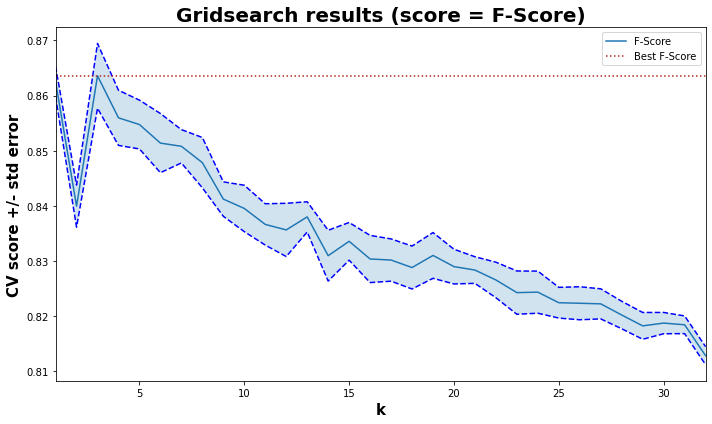

In [21]:
# initialize plot frame
plt.figure(figsize=(10, 6))

# plot scores with a log scale in x-axis
plt.plot(k_a_tester, scores, label="F-Score")
plt.plot(k_a_tester, scores + std_error, 'b--')
plt.plot(k_a_tester, scores - std_error, 'b--')

# control the translucency of the fill color with alpha=0.2
plt.fill_between(k_a_tester, scores + std_error, scores - std_error, alpha=0.2)

# plot best score
plt.axhline(np.max(scores), linestyle=':', color="firebrick", label="Best F-Score")

# format plot
plt.xlabel("k", fontweight="bold", fontsize=15)
plt.ylabel("CV score +/- std error", fontweight="bold", fontsize=15)
plt.xlim([k_a_tester[0], k_a_tester[-1]])
plt.title("Gridsearch results (score = F-Score)", fontweight="bold", fontsize=20)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

On remarque graphiquement que le meilleur F-Score est obtenu pour $k=3$, et c'est par ailleurs confirmé par le meilleur estimateur trouvé par l'algorithme de Cross-Validation :

In [22]:
grid.best_estimator_

KNeighborsClassifier(n_neighbors=3)

#### Question 10.b
Quel est le F-score correspondant au nombre de voisin optimal ?

In [23]:
y_predicted = grid.best_estimator_.predict(X_test_preprocessed)

f_score = f1_score(y_test, y_predicted)
f_score

0.8717156105100463

Le F-Score obtenu sur le jeu de test à l'aide de la valeur optimale calculée par l'algorithme de cross-validation est **0.87**. Il est meilleur d'un point par rapport au modèle avec $k=5$ (et, comme précédemment, plus élevé que l'algorithme naïf).

#### Question 10.c

Quel est le F-score, sur le jeu de test, d'un modèle obtenu en entraînant un algorithme des k plus proches voisins, avec le k que vous venez de déterminer, sur le jeu d'entraînement ? Commentez.

In [24]:
y_predicted = grid.best_estimator_.predict(X_train_preprocessed)

f_score = f1_score(y_train, y_predicted)
f_score

0.9301128489408037

Comme on peut s'y attendre, ce **F-Score est très élevé**. Il est même encore plus élevé que ce qu'on avait obtenu à la question 6, où l'on calculait déjà le F-Score sur le jeu d'entraînement. Cela est cohérent, puisque la valeur de l'hyperparamètre $k=3$ a été choisie car elle est optimale (alors que celle de $k=5$ était arbitraire).

## [À partir de la PC 5] Régression logistique

### Régression logistique non-régularisée

#### Question 11.a

Entraînez une régression logistique non-régularisée sur le jeu d'entraînement.

__Conseils :__
* Vous trouverez les outils nécessaires dans la classe `LogisticRegression` du module `linear_model` de `scikit-learn` ; il s'agit ainsi d'une variante de la PC5. Comme toujours, référez-vous à la [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
* Pour ne pas avoir de régularisation, utilisez `penalty='none'`

In [27]:
from sklearn.linear_model import LogisticRegression

In [48]:
regre_logis = LogisticRegression(penalty='none')
regre_logis.fit(X_train_preprocessed, y_train)

LogisticRegression(penalty='none')

#### Question 11.b
Évaluez le F-score de cette régression logistique non-régularisée sur le jeu de test.

In [49]:
y_predicted = regre_logis.predict(X_test_preprocessed)

f_score = f1_score(y_test, y_predicted)
f_score

0.7085714285714286

Le F-score de cette régression logistique non-régularisée est 0,71. Il est très faible par rapport aux résultats obtenus précédemment, presque autant que celui de l'algorithme naïf.

#### Question 12
Vous attendez-vous à ce qu'utiliser une régularisation l2 améliore les performances du modèle ? Pourquoi ?

On s'attend à ce que la régularisation l2 améliore les performances du modèle. En effet, elle permettra au modèle de moins se spécialiser, et donc d'être moins collé au jeu d'entraînement. Les prédictions sur le jeu de test devrait donc être mailleures.

#### Question 13.a
Déterminez par validation croisée une valeur optimale du coefficient de régularisation d'une régression logistique avec régularisation ridge.

In [42]:
# define model and alpha values to evaluate
regre_logis = LogisticRegression(penalty='l2')
Cs = np.logspace(-3, 1, 30)

# define gridsearch
tuned_parameters = [{'C': Cs}]
nb_folds = 5
grid = GridSearchCV(regre_logis, tuned_parameters, cv=nb_folds, refit=False, verbose=3)

# run gridsearch
grid.fit(X_train_preprocessed, y_train)

# get R2 (default score with Lasso models)
scores = grid.cv_results_['mean_test_score']
scores_std = grid.cv_results_['std_test_score']

# compute standard errors
std_error = scores_std / np.sqrt(nb_folds)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END ...........................C=0.001;, score=0.690 total time=   0.0s
[CV 2/5] END ...........................C=0.001;, score=0.686 total time=   0.0s
[CV 3/5] END ...........................C=0.001;, score=0.699 total time=   0.0s
[CV 4/5] END ...........................C=0.001;, score=0.679 total time=   0.0s
[CV 5/5] END ...........................C=0.001;, score=0.673 total time=   0.0s
[CV 1/5] END ...........C=0.0013738237958832624;, score=0.695 total time=   0.0s
[CV 2/5] END ...........C=0.0013738237958832624;, score=0.688 total time=   0.0s
[CV 3/5] END ...........C=0.0013738237958832624;, score=0.701 total time=   0.0s
[CV 4/5] END ...........C=0.0013738237958832624;, score=0.682 total time=   0.0s
[CV 5/5] END ...........C=0.0013738237958832624;, score=0.670 total time=   0.0s
[CV 1/5] END ...........C=0.0018873918221350976;, score=0.700 total time=   0.0s
[CV 2/5] END ...........C=0.0018873918221350976

[CV 1/5] END ..............C=0.7880462815669912;, score=0.708 total time=   0.0s
[CV 2/5] END ..............C=0.7880462815669912;, score=0.698 total time=   0.0s
[CV 3/5] END ..............C=0.7880462815669912;, score=0.708 total time=   0.0s
[CV 4/5] END ..............C=0.7880462815669912;, score=0.698 total time=   0.0s
[CV 5/5] END ..............C=0.7880462815669912;, score=0.692 total time=   0.0s
[CV 1/5] END ..............C=1.0826367338740541;, score=0.708 total time=   0.0s
[CV 2/5] END ..............C=1.0826367338740541;, score=0.698 total time=   0.0s
[CV 3/5] END ..............C=1.0826367338740541;, score=0.708 total time=   0.0s
[CV 4/5] END ..............C=1.0826367338740541;, score=0.697 total time=   0.0s
[CV 5/5] END ..............C=1.0826367338740541;, score=0.692 total time=   0.0s
[CV 1/5] END ..............C=1.4873521072935119;, score=0.709 total time=   0.0s
[CV 2/5] END ..............C=1.4873521072935119;, score=0.698 total time=   0.0s
[CV 3/5] END ..............C

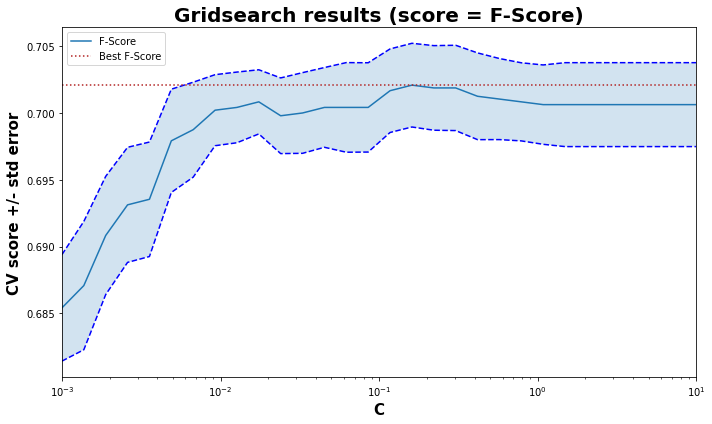

In [50]:
# initialize plot frame
plt.figure(figsize=(10, 6))

# plot scores with a log scale in x-axis
plt.semilogx(Cs, scores, label="F-Score")
plt.semilogx(Cs, scores + std_error, 'b--')
plt.semilogx(Cs, scores - std_error, 'b--')

# control the translucency of the fill color with alpha=0.2
plt.fill_between(Cs, scores + std_error, scores - std_error, alpha=0.2)

# plot best score
plt.axhline(np.max(scores), linestyle=':', color="firebrick", label="Best F-Score")

# format plot
plt.xlabel("C", fontweight="bold", fontsize=15)
plt.ylabel("CV score +/- std error", fontweight="bold", fontsize=15)
plt.xlim([Cs[0], Cs[-1]])
plt.title("Gridsearch results (score = F-Score)", fontweight="bold", fontsize=20)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [51]:
i_optim = np.argmax(scores)
C_opt = Cs[i_optim]

print("Lambda optimal : ",C_opt)

Lambda optimal :  0.16102620275609392


#### Question 13.b
Quel est le F-score, sur le jeu de test, d'une régression logistique avec régularisation ridge et ce coefficient de régularisation optimal, entraînée sur le jeu d'entraînement ?

In [52]:
regre_logis_ridge = LogisticRegression(penalty='l2', C=C_opt)
regre_logis_ridge.fit(X_train_preprocessed, y_train)

y_predicted = regre_logis_ridge.predict(X_test_preprocessed)

f_score = f1_score(y_test, y_predicted)
f_score

0.7085714285714286

#### Question 13.c
Commentez ce résultat en regard de votre réponse à la question 12.

Il n'y a en fait eu aucun changmeent...

#### Question 14

Entraînez une forêt aléatoire sur le jeu d'entraînement et évaluez son F-score sur le jeu de test.

__Conseils :__
* Vous trouverez les outils nécessaires dans la classe `RandomForestClassifier` du module `ensemble` de `scikit-learn`.
* Choisissez le nombre d'arbres par validation croisée.

## Modèle final

#### Question 15.a
Visualisez les performances des différents modèles (et pré-traitements) que vous avez évalués sur le jeu de test.

#### Question 15.b
Utilisez cette figure pour __sélectionner votre modèle favori__. Quel pré-traitement choisissez-vous ? Quel algorithme choisissez-vous, avec quel hyper-paramètre ? 

#### Question 16.a
Chargez les données privées de `data/foret_prive.tsv` pour obtenir un array `X_private`. Le fichier suit la même syntaxe que `data/foret_public.tsv`, mais sans la colonne des étiquettes.

#### Question 16.b
Appliquez le pré-traitement que vous avez choisi à l'intégralité du jeu de données public `X_public` pour obtenir `X_public_preprocessed`.

#### Question 16.c
Appliquez à `X_private` le pré-traitement que vous avez choisi ; enregistrez le résultat dans `X_private_preprocessed`.

#### Question 16.d
Entraînez l'algorithme que vous avez sélectionné sur l'intégralité des données publiques `(X_public_processed, y_public)`. 

#### Question 16.e
Prédisez les étiquettes de `X_private_preprocessed` ; enregistrez le résultat dans un array `y_pred_final`

#### Question 16.f
Utilisez le code suivant pour créer le fichier de prédictions que vous rendrez. 

__Attention__ Si vous ouvrez ce fichier avec un programme externe type Microsoft Excel ou LibreOffice Calc pour le lire, il est possible que ce programme modifie le fichier sans que vous ne le réalisiez. Préférez utiliser une commande bash type `less` ou `cat` ou éditeur de texte simple ; ou alors assurez-vous de relancer la commande.

In [ ]:
# Save array to file
np.savetxt("test_file.tsv", 
           y_pred_final,
           fmt=('%d'), 
           header='Prediction',
           delimiter='\t', comments="")

## Bonus

1. En alternative au F-score, utilisez des courbes ROC (et l'aire sous ces courbes) pour comparer vos modèles. Attention à utiliser les méthodes `predict_proba()` plutôt que `predict()` pour obtenir des scores non-seuillés plutôt que des prédictions binaires. Documentation pertinente : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html et  https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html.

1. Explorez d'autres pré-traitements (comme par exemple le fait de réduire la dimension des données) et d'autres algorithmes d'apprentissage implémentés dans scikit-learn (par exemple SVM, perceptrons multi-couches) pour essayer d'améliorer vos prédictions et reprenez la question 15.